In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:

# load and clean-up data
from numpy import nan
from pandas import read_csv
# univariate multi-step lstm
# import library 
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


## Preparing Data

In [ ]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Belawan")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1999-07-10 15:00:00,1,0.750,2.726197
1,1999-07-10 16:00:00,2,0.750,2.608670
2,1999-07-10 17:00:00,3,0.750,3.021065
3,1999-07-10 18:00:00,4,0.688,3.464277
4,1999-07-10 19:00:00,5,0.688,3.940771
...,...,...,...,...
437,1999-07-28 20:00:00,438,0.656,2.244146
438,1999-07-28 21:00:00,439,0.500,1.601026
439,1999-07-28 22:00:00,440,0.500,1.483258
440,1999-07-28 23:00:00,441,0.500,1.312014


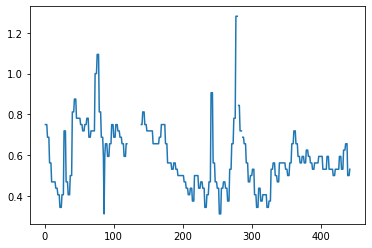

In [ ]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [ ]:
import copy
data_raw = copy.deepcopy(data)

### handling outliers

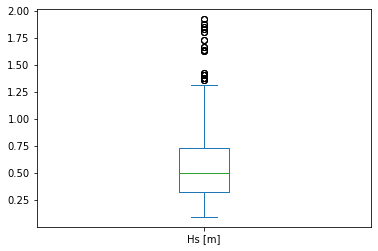

In [ ]:
data['Hs [m]'].plot(kind='box', sharex=False, sharey=False)
plt.show()

In [ ]:
# calculate q1, q3, iqr 
q1 = data['Hs [m]'].quantile(0.25)
q3 = data['Hs [m]'].quantile(0.75)
iqr = q3 - q1

In [ ]:
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ]

624     1.828
625     1.828
626     1.828
627     1.922
628     1.922
629     1.922
630     1.734
631     1.734
632     1.734
633     1.406
634     1.406
635     1.406
648     1.852
649     1.852
650     1.852
651     1.875
652     1.875
653     1.875
654     1.805
655     1.805
656     1.805
657     1.406
658     1.406
659     1.406
672     1.641
673     1.641
674     1.641
675     1.383
676     1.383
677     1.383
1449    1.383
1450    1.383
1451    1.383
1497    1.664
1498    1.664
1499    1.664
1500    1.359
1501    1.359
1502    1.359
2049    1.625
2050    1.625
2051    1.625
2277    1.422
2278    1.422
2279    1.422
Name: Hs [m], dtype: float64

In [ ]:
# outlier atas
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ] = np.nan

#outlier bawah
data['Hs [m]'].loc[(data['Hs [m]']< q1-(1.5*iqr)) & (data['Hs [m]']>= q1-(3*iqr)) ] = np.nan

# nilai ekstrim bawah
data['Hs [m]'].loc[data['Hs [m]']> q3 + (3*iqr) ] = np.nan

# nilai ekstrim atas
data['Hs [m]'].loc[data['Hs [m]']< q1 - (3*iqr) ] = np.nan

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
data.head()

,Date,Hours,Hs [m],Angin [m/s]
0,1999-01-12 00:00:00,1,0.281,3.450012
1,1999-01-12 01:00:00,2,0.281,3.195916
2,1999-01-12 02:00:00,3,0.281,3.480425
3,1999-01-12 03:00:00,4,0.234,3.734589
4,1999-01-12 04:00:00,5,0.234,3.478974


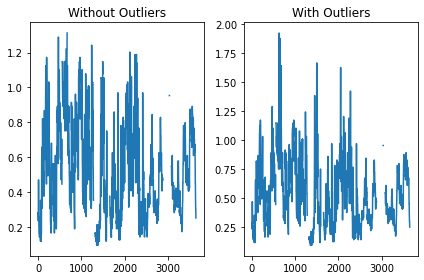

In [ ]:
plt.subplot(121)
plt.plot(data['Hs [m]'])
plt.title('Without Outliers')

plt.subplot(122)
plt.plot(data_raw['Hs [m]'])
plt.title('With Outliers')

plt.tight_layout()

### Interpolation

In [ ]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [ ]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [ ]:
# drop NaN value in dataframe data
data = data.dropna()

In [ ]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [ ]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [ ]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [ ]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [ ]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-15-86623d2f7eed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Hs [m]'][i-1] = y_fc(i)
<ipython-input-15-86623d2f7eed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Hs [m]'][i-1] = y_fq(i)
<ipython-input-15-86623d2f7eed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Hs [m]'][i-1] = y_fl(i)


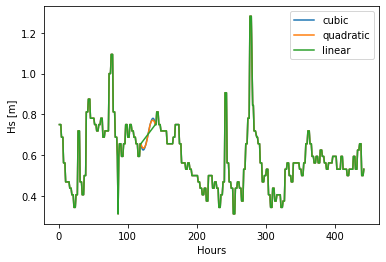

In [ ]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

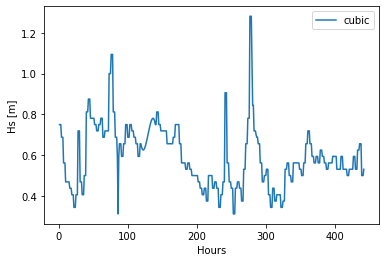

In [ ]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

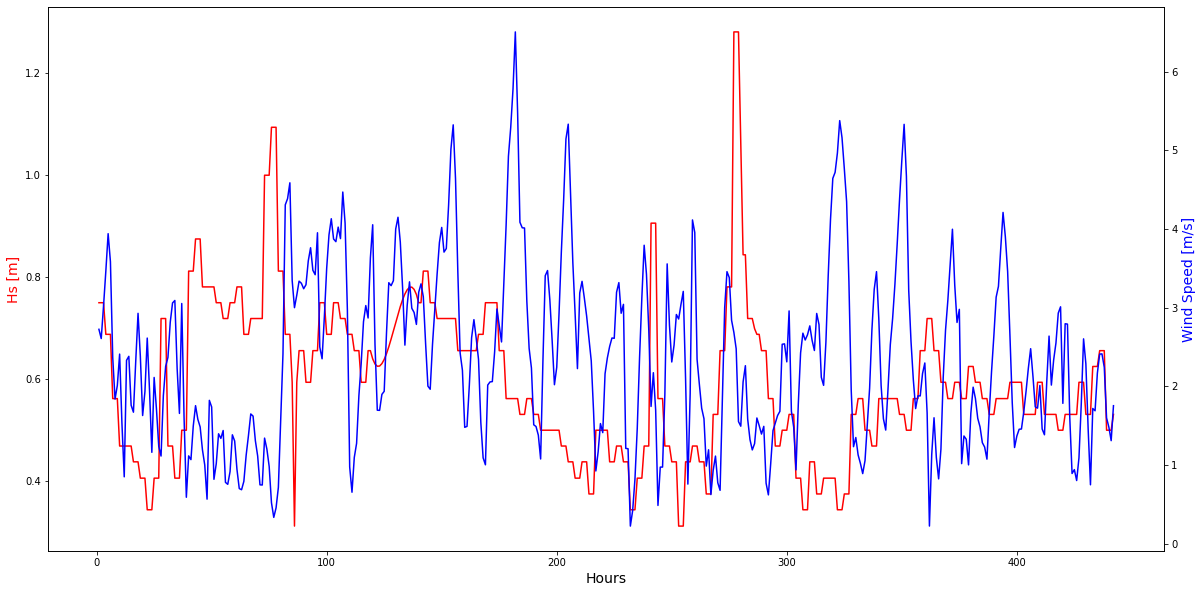

In [ ]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

### splitting data

In [ ]:
data_swh = data2['Hs [m]']
type(data_swh), data_swh.shape

(pandas.core.series.Series, (442,))

In [ ]:
len(data_swh)

442

In [ ]:
data_swh[1:5]

1    0.750
2    0.750
3    0.688
4    0.688
Name: Hs [m], dtype: float64

In [ ]:
data_swh[5:8]

5    0.688
6    0.562
7    0.562
Name: Hs [m], dtype: float64

**Pembagian data**

train = data 70% --> 1 - 2556

val = data 10% --> 2557 - 2928

test = data 20% --> 2929 - 3648

In [ ]:
train = data_swh[:300]
val = data_swh[300:348]
test = data_swh[348:432]
train.shape, val.shape, test.shape

((300,), (48,), (84,))

In [ ]:
# resturvture into windows of 12 hours data
train = array(split(train, round(len(train)/12)))
val = array(split(val, round(len(val)/12)))
test = array(split(test, round(len(test)/12)))
train.shape, val.shape, test.shape

((25, 12), (4, 12), (7, 12))

In [ ]:
n_input,n_out = 10,12
data_train = train.reshape((train.shape[0]*train.shape[1], ))
data_val = val.reshape((val.shape[0]*val.shape[1], ))
data_train.shape, data_val.shape

((300,), (48,))

In [ ]:
len(data_train)

300

In [ ]:
def split_into_xy(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
n_steps_in, n_steps_out = 10, 12
X_train, y_train = split_into_xy(data_train,n_steps_in, n_steps_out)
X_val, y_val = split_into_xy(data_val,n_steps_in, n_steps_out)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((279, 10), (279, 12), (27, 10), (27, 12))

In [ ]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_train.shape,X_val.shape

((279, 10, 1), (27, 10, 1))

## Model

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(100, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(100, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(60, activation='relu')))
model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 200)               161600    
                                                                 
 repeat_vector_16 (RepeatVec  (None, 12, 200)          0         
 tor)                                                            
                                                                 
 lstm_21 (LSTM)              (None, 200)               320800    
                                                                 
 repeat_vector_17 (RepeatVec  (None, 12, 200)          0         
 tor)                                                            
                                                                 
 lstm_22 (LSTM)              (None, 100)               120400    
                                                                 
 repeat_vector_18 (RepeatVec  (None, 12, 100)         

In [ ]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4158 - root_mean_squared_error: 0.6449

9/9 [==============================] - 23s 2s/step - loss: 0.4158 - root_mean_squared_error: 0.6449 - val_loss: 0.2149 - val_root_mean_squared_error: 0.4636
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.4047 - root_mean_squared_error: 0.6362

9/9 [==============================] - 11s 1s/step - loss: 0.4047 - root_mean_squared_error: 0.6362 - val_loss: 0.2062 - val_root_mean_squared_error: 0.4541
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.3891 - root_mean_squared_error: 0.6238

9/9 [==============================] - 11s 1s/step - loss: 0.3891 - root_mean_squared_error: 0.6238 - val_loss: 0.1937 - val_root_mean_squared_error: 0.4401
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.3636 - root_mean_squared_error: 0.6030

9/9 [==============================] - 12s 1s/step - loss: 0.3636 - root_mean_squared_error: 0.6030 - val_loss: 0.1727 - val_root_mean_squared_error: 0.4156
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.3125 - root_mean_squared_error: 0.5590

9/9 [==============================] - 11s 1s/step - loss: 0.3125 - root_mean_squared_error: 0.5590 - val_loss: 0.1303 - val_root_mean_squared_error: 0.3610
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1941 - root_mean_squared_error: 0.4405

9/9 [==============================] - 12s 1s/step - loss: 0.1941 - root_mean_squared_error: 0.4405 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2018
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 0.0943 - root_mean_squared_error: 0.3071

9/9 [==============================] - 13s 2s/step - loss: 0.0943 - root_mean_squared_error: 0.3071 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1746
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 0.0792 - root_mean_squared_error: 0.2815

9/9 [==============================] - 10s 1s/step - loss: 0.0792 - root_mean_squared_error: 0.2815 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 0.0709 - root_mean_squared_error: 0.2663

9/9 [==============================] - 12s 1s/step - loss: 0.0709 - root_mean_squared_error: 0.2663 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432
Epoch 10/100
9/9 [==============================] - 1s 116ms/step - loss: 0.0673 - root_mean_squared_error: 0.2595 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1468
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 0.0623 - root_mean_squared_error: 0.2496

9/9 [==============================] - 12s 1s/step - loss: 0.0623 - root_mean_squared_error: 0.2496 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1357
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 0.0572 - root_mean_squared_error: 0.2391

9/9 [==============================] - 11s 1s/step - loss: 0.0572 - root_mean_squared_error: 0.2391 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1271
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.2261

9/9 [==============================] - 12s 1s/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 14/100
9/9 [==============================] - ETA: 0s - loss: 0.0425 - root_mean_squared_error: 0.2062

9/9 [==============================] - 13s 2s/step - loss: 0.0425 - root_mean_squared_error: 0.2062 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 15/100
9/9 [==============================] - 2s 174ms/step - loss: 0.0386 - root_mean_squared_error: 0.1965 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 16/100
9/9 [==============================] - ETA: 0s - loss: 0.0367 - root_mean_squared_error: 0.1917

9/9 [==============================] - 10s 1s/step - loss: 0.0367 - root_mean_squared_error: 0.1917 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 17/100
9/9 [==============================] - 2s 207ms/step - loss: 0.0358 - root_mean_squared_error: 0.1892 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 18/100
9/9 [==============================] - 2s 208ms/step - loss: 0.0341 - root_mean_squared_error: 0.1846 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 19/100
9/9 [==============================] - 1s 154ms/step - loss: 0.0328 - root_mean_squared_error: 0.1811 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 20/100
9/9 [==============================] - 1s 119ms/step - loss: 0.0322 - root_mean_squared_error: 0.1796 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1223
Epoch 21/100
9/9 [==============================] - 1s 119ms/step - loss: 0.0310 - root_mean_squared_error: 0.1761 - val_loss: 0.0129 - val_root_mean_squar

9/9 [==============================] - 12s 1s/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 24/100
9/9 [==============================] - 1s 114ms/step - loss: 0.0265 - root_mean_squared_error: 0.1629 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 25/100
9/9 [==============================] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.1614

9/9 [==============================] - 11s 1s/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 26/100
9/9 [==============================] - 1s 136ms/step - loss: 0.0250 - root_mean_squared_error: 0.1582 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 27/100
9/9 [==============================] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1642

9/9 [==============================] - 12s 1s/step - loss: 0.0270 - root_mean_squared_error: 0.1642 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931
Epoch 28/100
9/9 [==============================] - 2s 241ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 29/100
9/9 [==============================] - 2s 240ms/step - loss: 0.0264 - root_mean_squared_error: 0.1626 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.0259 - root_mean_squared_error: 0.1609

9/9 [==============================] - 11s 1s/step - loss: 0.0259 - root_mean_squared_error: 0.1609 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886
Epoch 31/100
9/9 [==============================] - 2s 210ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 32/100
9/9 [==============================] - 2s 204ms/step - loss: 0.0249 - root_mean_squared_error: 0.1579 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020
Epoch 33/100
9/9 [==============================] - ETA: 0s - loss: 0.0256 - root_mean_squared_error: 0.1601

9/9 [==============================] - 9s 1s/step - loss: 0.0256 - root_mean_squared_error: 0.1601 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 34/100
9/9 [==============================] - 2s 176ms/step - loss: 0.0253 - root_mean_squared_error: 0.1592 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955
Epoch 35/100
9/9 [==============================] - 2s 207ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 36/100
9/9 [==============================] - 2s 192ms/step - loss: 0.0253 - root_mean_squared_error: 0.1590 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 37/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 38/100
9/9 [==============================] - 1s 114ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0088 - val_root_mean_square

9/9 [==============================] - 12s 1s/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 43/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 44/100
9/9 [==============================] - 1s 121ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0964
Epoch 45/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 46/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 47/100
9/9 [==============================] - 1s 122ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0085 - val_root_mean_squar

9/9 [==============================] - 11s 1s/step - loss: 0.0226 - root_mean_squared_error: 0.1505 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 49/100
9/9 [==============================] - ETA: 0s - loss: 0.0230 - root_mean_squared_error: 0.1516

9/9 [==============================] - 13s 2s/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 50/100
9/9 [==============================] - 1s 121ms/step - loss: 0.0229 - root_mean_squared_error: 0.1513 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 51/100
9/9 [==============================] - 1s 118ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 52/100
9/9 [==============================] - 1s 115ms/step - loss: 0.0233 - root_mean_squared_error: 0.1527 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 53/100
9/9 [==============================] - 1s 115ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 54/100
9/9 [==============================] - 1s 135ms/step - loss: 0.0229 - root_mean_squared_error: 0.1513 - val_loss: 0.0090 - val_root_mean_squar

9/9 [==============================] - 11s 1s/step - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 57/100
9/9 [==============================] - 1s 119ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0803
Epoch 58/100
9/9 [==============================] - 2s 211ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 59/100
9/9 [==============================] - 2s 209ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 60/100
9/9 [==============================] - 1s 157ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 61/100
9/9 [==============================] - 1s 120ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.0070 - val_root_mean_squar

9/9 [==============================] - 10s 1s/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 72/100
9/9 [==============================] - ETA: 0s - loss: 0.0226 - root_mean_squared_error: 0.1504

9/9 [==============================] - 13s 2s/step - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 73/100
9/9 [==============================] - 1s 118ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 74/100
9/9 [==============================] - 1s 124ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 75/100
9/9 [==============================] - 2s 204ms/step - loss: 0.0216 - root_mean_squared_error: 0.1470 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 76/100
9/9 [==============================] - 2s 209ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 77/100
9/9 [==============================] - 2s 175ms/step - loss: 0.0223 - root_mean_squared_error: 0.1492 - val_loss: 0.0060 - val_root_mean_squar

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [ ]:
history = [x for x in val]
predictions = list()
for i in range(len(test)):
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], ))
  input_x = data[-n_input:, ]
  input_x = input_x.reshape((1, input_x.shape[0], 1))
  # predict the week
  yhat = model.predict(input_x, verbose=0)
  yhat_sequence = yhat[0]
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  history.append(test[i, :])

In [ ]:
prediksi = array(predictions)
observasi = test
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [ ]:
observasi

array([[0.531],
       [0.531],
       [0.531],
       [0.5  ],
       [0.5  ],
       [0.5  ],
       [0.562],
       [0.562],
       [0.562],
       [0.656],
       [0.656],
       [0.656],
       [0.719],
       [0.719],
       [0.719],
       [0.656],
       [0.656],
       [0.656],
       [0.594],
       [0.594],
       [0.594],
       [0.562],
       [0.562],
       [0.562],
       [0.594],
       [0.594],
       [0.594],
       [0.562],
       [0.562],
       [0.562],
       [0.625],
       [0.625],
       [0.625],
       [0.594],
       [0.594],
       [0.594],
       [0.562],
       [0.562],
       [0.562],
       [0.531],
       [0.531],
       [0.531],
       [0.562],
       [0.562],
       [0.562],
       [0.562],
       [0.562],
       [0.562],
       [0.594],
       [0.594],
       [0.594],
       [0.594],
       [0.594],
       [0.594],
       [0.531],
       [0.531],
       [0.531],
       [0.531],
       [0.531],
       [0.531],
       [0.594],
       [0.594],
       [

In [ ]:
prediksi

array([[0.47888377],
       [0.5610878 ],
       [0.5574616 ],
       [0.5590258 ],
       [0.5598446 ],
       [0.55973697],
       [0.56171525],
       [0.56679314],
       [0.5699728 ],
       [0.5686153 ],
       [0.56864685],
       [0.5698565 ],
       [0.54602796],
       [0.61008126],
       [0.60094994],
       [0.6041026 ],
       [0.60112983],
       [0.5992068 ],
       [0.60146976],
       [0.60506773],
       [0.60353464],
       [0.6020595 ],
       [0.60292304],
       [0.6059119 ],
       [0.48616916],
       [0.5663005 ],
       [0.5618204 ],
       [0.5633676 ],
       [0.5636369 ],
       [0.563221  ],
       [0.56513023],
       [0.5702761 ],
       [0.57297117],
       [0.5715062 ],
       [0.5715132 ],
       [0.5729015 ],
       [0.51711   ],
       [0.58964264],
       [0.58268684],
       [0.58493006],
       [0.58353794],
       [0.58230186],
       [0.58428526],
       [0.58903843],
       [0.58932   ],
       [0.58799076],
       [0.5879992 ],
       [0.590

In [ ]:
import pandas as pd
test_results = pd.DataFrame(data={'Univariate':prediksi.flatten(), 
                                   'Actuals':observasi.flatten()})
test_results

,Univariate,Actuals
0,0.478884,0.531
1,0.561088,0.531
2,0.557462,0.531
3,0.559026,0.500
4,0.559845,0.500
...,...,...
79,0.534535,0.594
80,0.539603,0.594
81,0.541009,0.531
82,0.541021,0.531


In [ ]:
prediksi = array(predictions)
observasi = test[:, :, ]
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [ ]:
test_results['Date'] = data2['Date'].iloc[348:432].values
test_results.head()

,Univariate,Actuals,Date
0,0.478884,0.531,1999-07-25 03:00:00
1,0.561088,0.531,1999-07-25 04:00:00
2,0.557462,0.531,1999-07-25 05:00:00
3,0.559026,0.500,1999-07-25 06:00:00
4,0.559845,0.500,1999-07-25 07:00:00


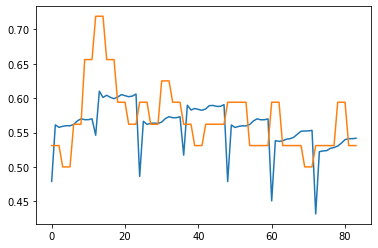

In [ ]:
plt.plot(test_results['Univariate'])
plt.plot(test_results['Actuals'])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Univariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',fillcolor='#ff0000',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [ ]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Univariate'])
RMSE = math.sqrt(MSE)
RMSE

0.05258930081474782

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Univariate'])
corr

0.26753142787882256

In [ ]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Univariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

-0.010999795453889044

In [ ]:
test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multi-step/univariate_12jam_lstm_belawan.csv')